# Detection of Thunderstorms

This notebook is meant to work in a very straightforward way:

At the top, after the necessary imports, there are to be inserted temperature and pressure data in the .sac format. 
They should span the same time range, have a sampling rate of ideally of 1 per minute or even better and as much time as possible.
If their traces don't perfectly coindice, the program will make up for that and cut the analysed period down to the time intervals where both overlap.

The output in the end consists of the periods of time where there is sufficient data and of the proposed event times for thunderstorms.
It comes in a .csv file where one column contains one valid time intervals at the top and all of the start and end times of all the storms in the according interval.

If this suffices, after inserting the data in "Insert Data" one "run all" should work without problems and the results will appear at the bottom of the notebook. 
For the more interested user, all of the steps of the algorithm will be explained in the notebook.

## Import of Necessary Libraries

In [345]:
# Basics
import numpy as np
import math
import bisect

#plots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#interpolation
import scipy
from scipy.optimize import lsq_linear, curve_fit
from scipy.optimize import minimize as scipy_minimize

#seismic data handling
import obspy as ob
from obspy import read, UTCDateTime, Stream, Trace
import calendar
import datetime
from datetime import datetime, timedelta, time
import csv
import pandas as pd

#system and file handling
import os
from glob import glob

## Data Input

Insert temperature and pressure data here. Each should be in its own folder in .sac format in UTC. Ideally, both span over the same time period as having both temperature and pressure data at the same time is essential for the algorithm to work

In [ ]:
temp_folder = 'Massachusetts/HRV LKO' # Insert path to temperature folder
press_folder = 'Massachusetts/HRV LDO' # Insert path to pressure folder
time_diff = -4 # Time difference from UTC to local winter time (e.g. -4 for New York, -7 for New Mexico)

## Processing

### Making the Data Accessible for our Purposes

In [347]:
#Making data accessible for the program
tempsac_files = sorted(glob(os.path.join(temp_folder, "*.SAC")))
temp_traces = [read(f)[0] for f in tempsac_files]

presssac_files = sorted(glob(os.path.join(press_folder, "*.SAC")))
press_traces = [read(f)[0] for f in presssac_files]

In [348]:
startyear = np.min([temp_traces[0].stats.starttime.year, press_traces[0].stats.starttime.year])  #start of the data
endyear = np.max([temp_traces[-1].stats.endtime.year, press_traces[-1].stats.endtime.year])  #end of the data
number_of_years = endyear - startyear + 1
day = 24 * 60 * 60  # seconds in a day

In [349]:
#erase microseconds - not relevant for our time scales
for i in range(len(temp_traces)):
    if temp_traces[i].stats.starttime.microsecond != 0:
        microseconds = round(temp_traces[i].stats.starttime.microsecond, -6)
        if microseconds == 0:
            temp_traces[i].stats.starttime = temp_traces[i].stats.starttime.replace(microsecond=0)
        elif microseconds == 1e6:
            temp_traces[i].stats.starttime = temp_traces[i].stats.starttime.replace(microsecond=0) + timedelta(seconds=1)

for i in range(len(press_traces)):
    if press_traces[i].stats.starttime.microsecond != 0:
        microseconds = round(press_traces[i].stats.starttime.microsecond, -6)
        if microseconds == 0:
            press_traces[i].stats.starttime = press_traces[i].stats.starttime.replace(microsecond=0)
        elif microseconds == 1e6:
            press_traces[i].stats.starttime = press_traces[i].stats.starttime.replace(microsecond=0) + timedelta(seconds=1)


In [350]:
# Create Stream objects, important for the next step
temp_stream = Stream(temp_traces)
press_stream = Stream(press_traces)

#Trim pressure and temperature streams to the same time intervals
a = UTCDateTime(startyear, 1, 1)
b = press_traces[0].stats.starttime
temp_stream.cutout(a, b)
a = press_traces[-1].stats.endtime
b = UTCDateTime(2030, 1, 1)
temp_stream.cutout(a, b)
for i in range(len(press_traces)-1):
    a = press_traces[i].stats.endtime
    b = press_traces[i+1].stats.starttime
    temp_stream.cutout(a, b)

temp_traces = temp_stream.traces

a = UTCDateTime(startyear, 1, 1)
b = temp_traces[0].stats.starttime
press_stream.cutout(a, b)
a = temp_traces[-1].stats.endtime
b = UTCDateTime(2100, 1, 1)
press_stream.cutout(a, b)
for i in range(len(temp_traces)-1):
    a = temp_traces[i].stats.endtime
    b = temp_traces[i+1].stats.starttime
    press_stream.cutout(a, b)

press_traces = press_stream.traces

In [351]:
#store data in arrays
press_arrays = [st.data for st in press_traces]
temp_arrays = [st.data for st in temp_traces]

We don't need recordings every minute or even second for detecting events like thunderstorms. 
Thus, we reduce the sampling rate to one per ten minutes. 
That way, we create a standardized set of 144 data points each day, starting exactly at midnight and each ten minutes apart.

In [352]:
# reducing the sampling rate
r_press_arrays = []
r_temp_arrays = []
r_times = []

for (index, stream) in enumerate(press_arrays):
    start_time = press_traces[index].stats.starttime
    end_time = press_traces[index].stats.endtime
    #Round to next ten minutes from the start of the stream:
    new_start_min = int(math.ceil((start_time.minute + start_time.second/60 + start_time.microsecond/6e7) / 10) * 10)
    if new_start_min == 60:
        new_start_min = 0
        new_start_time = UTCDateTime(start_time.year, start_time.month, start_time.day, start_time.hour, new_start_min) + timedelta(hours=1)
    else:
        new_start_time = UTCDateTime(start_time.year, start_time.month, start_time.day, start_time.hour, new_start_min)
    #Round to the previous ten minutes from the end of the stream:
    new_end_min = int(math.floor((end_time.minute + end_time.second/60 + end_time.microsecond/6e7) / 10) * 10)
    new_end_time = UTCDateTime(end_time.year, end_time.month, end_time.day, end_time.hour, new_end_min)

    #Store stream if and only if it is longer than a day. Otherwise, it won't be of use
    new_length = int((new_end_time - new_start_time) / 600 + 1)
    if new_length < 144:
        continue
    new_stream = np.zeros(new_length)

    #Fill new stream with averaged values
    raw_data_sampling_rate = press_traces[index].stats.sampling_rate # measured in Hz
    data_points_per_window = int(600 * raw_data_sampling_rate)
    for i in range(new_length):
        mid_index = int((new_start_time - start_time) + i * data_points_per_window)
        if i == 0:
            new_stream[i] = np.mean(stream[:mid_index + data_points_per_window//2])
        elif i == new_length - 1:
            new_stream[i] = np.mean(stream[mid_index - data_points_per_window//2:])
        else:
            new_stream[i] = np.mean(stream[mid_index - data_points_per_window//2:mid_index + data_points_per_window//2])
    if new_length > 144:
        r_press_arrays.append(new_stream)

    #Also save time stamps for new data points
    new_times = np.zeros(new_length, dtype=UTCDateTime)
    new_times[0] = new_start_time + timedelta(hours=time_diff)
    for i in range(1, new_length):
        new_times[i] = new_start_time + timedelta(seconds=i * 600) + timedelta(hours=time_diff)
    if new_times[-1] != new_end_time + timedelta(hours=time_diff):
        print("That's odd")
    if new_length > 144:
        r_times.append(new_times)

# Repeat for temperatures
for (index, stream) in enumerate(temp_arrays):
    start_time = temp_traces[index].stats.starttime
    end_time = temp_traces[index].stats.endtime
    new_start_min = int(math.ceil((start_time.minute + start_time.second/60 + start_time.microsecond/6e7) / 10) * 10)
    if new_start_min == 60:
        new_start_min = 0
        new_start_time = UTCDateTime(start_time.year, start_time.month, start_time.day, start_time.hour, new_start_min) + timedelta(hours=1)
    else:
        new_start_time = UTCDateTime(start_time.year, start_time.month, start_time.day, start_time.hour, new_start_min)
    new_end_min = int(math.floor((end_time.minute + end_time.second/60 + end_time.microsecond/6e7) / 10) * 10)
    new_end_time = UTCDateTime(end_time.year, end_time.month, end_time.day, end_time.hour, new_end_min)

    new_length = int((new_end_time - new_start_time) / 600 + 1)
    if new_length < 144:
        continue
    new_stream = np.zeros(new_length)

    raw_data_sampling_rate = press_traces[index].stats.sampling_rate # measured in Hz
    data_points_per_window = int(600 * raw_data_sampling_rate)
    for i in range(new_length):
        mid_index = int((new_start_time - start_time) + i * data_points_per_window)
        if i == 0:
            new_stream[i] = np.mean(stream[:mid_index + data_points_per_window//2])
        elif i == new_length - 1:
            new_stream[i] = np.mean(stream[mid_index - data_points_per_window//2:])
        else:
            new_stream[i] = np.mean(stream[mid_index - data_points_per_window//2:mid_index + data_points_per_window//2])
    if new_length > 144:
        r_temp_arrays.append(new_stream)



From here on: Sampling rate 1 per 10 minutes

As we will take derivatives of the data stream later on, we will smoothen it out a little bit.
One just has to be very careful and should not make the window for that to big.
A too smooth stream will surprisingly make it harder for us to distinguish signal from noise later on.

In [353]:
def smooth_data(data, window_size=12):
    if len(data) < window_size:
        return data  # Not enough data to smooth
    smoothed_data = np.zeros_like(data)
    for i in range(len(data)):
        if i < window_size / 2:
            smoothed_data[i] = np.mean(data[:i + window_size // 2 + 1])
        elif i >= len(data) - window_size / 2:
            smoothed_data[i] = np.mean(data[i - window_size // 2:])
        else:
            smoothed_data[i] = np.mean(data[i - window_size // 2:i + window_size // 2 + 1])
    return smoothed_data

In [354]:
smooth_press_arrays = [smooth_data(stream, window_size=2) for stream in r_press_arrays]
smooth_temp_arrays = [smooth_data(stream, window_size=2) for stream in r_temp_arrays]

Another important measure is to remove long term weather trends.
Thunderstorms are a relatively short lived phenomenon after all and we want to observe exactly those changes without the influence of slowly changing weather systems.
We thus remove a 24 hour moving average from our data.

In [355]:
# Removing the 24 hour moving average
press_data = []
temp_data = []

for j in range(len(smooth_press_arrays)):
    stream = smooth_press_arrays[j]
    data = np.zeros_like(stream)
    if stream.shape[0] < 144:
        data[:] = stream - np.mean(stream)
        press_data.append(data)
        continue
    if j == len(smooth_press_arrays) - 1:
            for i in range(stream.shape[0]):
                if i < 72:
                    data[i] = stream[i] - np.mean(np.concatenate((stream[:i+72], smooth_press_arrays[j-1][-72 + i:])))
                elif i >= len(stream) - 72:
                    data[i] = stream[i] - np.mean(stream[len(stream) - 144:])
                else:
                    data[i] = stream[i] - np.mean(stream[i - 72:i + 72])
    elif j == 0:
        for i in range(stream.shape[0]):
            if i < 72:
                data[i] = stream[i] - np.mean(stream[:144])
            elif i >= len(stream) - 72:
                data[i] = stream[i] - np.mean(np.concatenate((stream[i - 72:], smooth_press_arrays[j+1][72 - (len(stream) - i):])))
            else:
                data[i] = stream[i] - np.mean(stream[i - 72:i + 72])
    else:
        for i in range(stream.shape[0]):
            if i < 72:
                data[i] = stream[i] - np.mean(np.concatenate((stream[:i+72], smooth_press_arrays[j-1][-72 + i:])))
            elif i >= len(stream) - 72:
                data[i] = stream[i] - np.mean(np.concatenate((stream[i - 72:], smooth_press_arrays[j+1][72 - (len(stream) - i):])))
            else:
                data[i] = stream[i] - np.mean(stream[i - 72:i + 72])
    press_data.append(data)

for stream in smooth_temp_arrays:
    data = np.zeros_like(stream)
    if stream.shape[0] < 144:
        data[:] = stream - np.mean(stream)
        temp_data.append(data)
        continue
    if j == len(smooth_temp_arrays) - 1:
            for i in range(stream.shape[0]):
                if i < 72:
                    data[i] = stream[i] - np.mean(np.concatenate((stream[:i+72], smooth_temp_arrays[j-1][-72 + i:])))
                elif i >= len(stream) - 72:
                    data[i] = stream[i] - np.mean(stream[len(stream) - 144:])
                else:
                    data[i] = stream[i] - np.mean(stream[i - 72:i + 72])
    elif j == 0:
        for i in range(stream.shape[0]):
            if i < 72:
                data[i] = stream[i] - np.mean(stream[:144])
            elif i >= len(stream) - 72:
                data[i] = stream[i] - np.mean(np.concatenate((stream[i - 72:], smooth_temp_arrays[j+1][72 - (len(stream) - i):])))
            else:
                data[i] = stream[i] - np.mean(stream[i - 72:i + 72])
    else:
        for i in range(stream.shape[0]):
            if i < 72:
                data[i] = stream[i] - np.mean(np.concatenate((stream[:i+72], smooth_temp_arrays[j-1][-72 + i:])))
            elif i >= len(stream) - 72:
                data[i] = stream[i] - np.mean(np.concatenate((stream[i - 72:], smooth_temp_arrays[j+1][72 - (len(stream) - i):])))
            else:
                data[i] = stream[i] - np.mean(stream[i - 72:i + 72])
    data /= 10
    temp_data.append(data)

In [356]:
# Observing 24 hour moving average (long term trends), will be useful too
press_moving_average = []
for j in range(len(smooth_press_arrays)):
    stream = smooth_press_arrays[j]
    avg = np.zeros_like(stream)
    if stream.shape[0] < 144:
        avg[:] = np.mean(stream)
        press_data.append(avg)
        continue
    if j == len(smooth_press_arrays) - 1:
            for i in range(stream.shape[0]):
                if i < 72:
                    avg[i] = np.mean(np.concatenate((stream[:i+72], smooth_press_arrays[j-1][-72 + i:])))
                elif i >= len(stream) - 72:
                    avg[i] = np.mean(stream[len(stream) - 144:])
                else:
                    avg[i] = np.mean(stream[i - 72:i + 72])
    elif j == 0:
        for i in range(stream.shape[0]):
            if i < 72:
                avg[i] = np.mean(stream[:144])
            elif i >= len(stream) - 72:
                avg[i] = np.mean(np.concatenate((stream[i - 72:], smooth_press_arrays[j+1][72 - (len(stream) - i):])))
            else:
                avg[i] = np.mean(stream[i - 72:i + 72])
    else:
        for i in range(stream.shape[0]):
            if i < 72:
                avg[i] = np.mean(np.concatenate((stream[:i+72], smooth_press_arrays[j-1][-72 + i:])))
            elif i >= len(stream) - 72:
                avg[i] = np.mean(np.concatenate((stream[i - 72:], smooth_press_arrays[j+1][72 - (len(stream) - i):])))
            else:
                avg[i] = np.mean(stream[i - 72:i + 72])
    press_moving_average.append(avg)

temp_moving_average = []
for stream in smooth_temp_arrays:
    avg = np.zeros_like(stream)
    if stream.shape[0] < 144:
        avg[:] = stream - np.mean(stream)
        temp_data.append(avg)
        continue
    if j == len(smooth_temp_arrays) - 1:
            for i in range(stream.shape[0]):
                if i < 72:
                    avg[i] = np.mean(np.concatenate((stream[:i+72], smooth_temp_arrays[j-1][-72 + i:])))
                elif i >= len(stream) - 72:
                    avg[i] = np.mean(stream[len(stream) - 144:])
                else:
                    avg[i] = np.mean(stream[i - 72:i + 72])
    elif j == 0:
        for i in range(stream.shape[0]):
            if i < 72:
                avg[i] = np.mean(stream[:144])
            elif i >= len(stream) - 72:
                avg[i] = np.mean(np.concatenate((stream[i - 72:], smooth_temp_arrays[j+1][72 - (len(stream) - i):])))
            else:
                avg[i] = np.mean(stream[i - 72:i + 72])
    else:
        for i in range(stream.shape[0]):
            if i < 72:
                avg[i] = np.mean(np.concatenate((stream[:i+72], smooth_temp_arrays[j-1][-72 + i:])))
            elif i >= len(stream) - 72:
                avg[i] = np.mean(np.concatenate((stream[i - 72:], smooth_temp_arrays[j+1][72 - (len(stream) - i):])))
            else:
                avg[i] = np.mean(stream[i - 72:i + 72])
    avg /= 10
    temp_moving_average.append(avg)

    press_moving_average_singular = np.concatenate(press_moving_average)
    temp_moving_average_singular = np.concatenate(temp_moving_average)

In [357]:
#Flatten the arrays - this will make navigating in the data easier
press = np.concatenate(press_data)
temp = np.concatenate(temp_data)
times = np.concatenate(r_times)
data = np.column_stack((temp, press))

n = len(press)

The data has some holes which we would like to avoid when plotting days or analysing data. 

To make up for that, we use a specific algorithm to determine whether one individual time window can be used properly and outputting the right indices if the answer is yes.
This is our most frequent use case and we want to efficiently code it only once.

In [358]:
#Can this specific time window be used?
def time_window_eval(starttime, endtime):
    if endtime < starttime or starttime > times[-1]:
        return False, 0, 0
    
    start_index = np.searchsorted(times, starttime)  # Find the index of the start time
    end_index = np.searchsorted(times, endtime)  # Find the index of the end time
    desired_length = int((endtime - starttime) / 600)
    if end_index - start_index == desired_length:
        return True, start_index, end_index
    else:
        return False, start_index, end_index

We also collect the indices after big gaps in time

In [359]:
start_indices = np.array([0])
for i in range(1, n):
    if times[i] - times[i-1] > 600:
        start_indices = np.append(start_indices, i)

In [360]:
# Get index of a specific time - important as we ultimately navigate within time and not just raw data
def get_index(target_time, direction="before"):
    if direction == "before":
        index = np.searchsorted(times, target_time, side='right') - 1
    elif direction == "after":
        index = np.searchsorted(times, target_time, side='left')
    return index

### Background Curves

Another important observation is that both temperature and pressure have a "typical" daily cycle.
This can vary from month to month and station to station but is a reocurring pattern that we want to have removed.

In [361]:
def avday(variable, start_time, end_time):
    if variable == "temp":
        v = 0
    elif variable == "press":
        v = 1
    
    avg_values = np.zeros(144)
    value_counts = np.zeros(144)

    start_index = 0
    end_index = n

    for i in range(n):
        if times[i] >= start_time:
            start_index = i
            break
        elif i == n - 1:
            start_index = n
    for i in range(start_index, n):
        if times[i] > end_time:
            end_index = i
            break
    
    for i in range(start_index, end_index):
        bin = int((times[i].hour * 6 + times[i].minute/10))
        avg_values[bin] += data[i, v]
        value_counts[bin] += 1

    for i in range(144):
        if value_counts[i] > 0:
            avg_values[i] /= value_counts[i]
        else:
            avg_values = np.zeros(144)
            break

    return np.array(avg_values)

The background cycles continuously change throughout the year. We take a broad average over one month, e.g. January, and average the daily behaviour of "all Januaries" in the data set.
We then move this averaging period by five days to capture a continuous picture.
Always moving the windowfive days leaves us with 73 different patterns for each temperature and pressure.

We also want to capture the pattern rather than deviations from it. 
We thus set up a correlation matrix to assess how similar e.g. January from 2010 is to January 2012.
Months that are similar to the rest are assigned a heavier weight for the averaging.

In [362]:
#store the data for later use
bg_temp_cycles = np.zeros((73, 144), dtype=float)
for j in range(73):
    # Collect data for one (translated) month for each year, store them
    curves = np.zeros((number_of_years, 144), dtype=float)
    for i in range(number_of_years):
        start_time = UTCDateTime(startyear + i, 1, 1) + 5 * day * j
        end_time = UTCDateTime(startyear + i, 2, 1) + 5 * day * j - 1
        avg_values_temp = avday("temp", start_time, end_time)
        curves[i, :] = avg_values_temp
    
    n_curves = curves.shape[0]

    #potential identically zero curves
    curve_norms = np.linalg.norm(curves, axis=1)
    nonzero_mask = curve_norms > 1e-8

    #correlation matrix for nonzero curves
    valid_curves = curves[nonzero_mask]
    correlation_matrix = np.corrcoef(valid_curves)

    # similarity scores and weights for curves
    similarity_scores = np.sum(correlation_matrix, axis=1) - 1  
    valid_weights = similarity_scores / np.sum(similarity_scores)

    cycle_weights = np.zeros(n_curves)
    cycle_weights[nonzero_mask] = valid_weights

    #weighted average of the curves
    weighted_avg_curve = np.sum(valid_curves * cycle_weights[nonzero_mask, np.newaxis], axis=0)
    bg_temp_cycles[j, :] = weighted_avg_curve

In [363]:
#same for pressure:
bg_press_cycles = np.zeros((73, 144), dtype=float)
for j in range(73):
    # Collect data for one (translated) month for each year, store them
    curves = np.zeros((number_of_years, 144), dtype=float)
    for i in range(number_of_years):
        start_time = UTCDateTime(startyear + i, 1, 1) + 5 * day * j
        end_time = UTCDateTime(startyear + i, 2, 1) + 5 * day * j - 1
        avg_values_press= avday("press", start_time, end_time)
        curves[i, :] = avg_values_press
    
    n_curves = curves.shape[0]

    #potential identically zero curves
    curve_norms = np.linalg.norm(curves, axis=1)
    nonzero_mask = curve_norms > 1e-8

    #correlation matrix for nonzero curves
    valid_curves = curves[nonzero_mask]
    correlation_matrix = np.corrcoef(valid_curves)

    # similarity scores and weights for curves
    similarity_scores = np.sum(correlation_matrix, axis=1) - 1  
    valid_weights = similarity_scores / np.sum(similarity_scores)

    cycle_weights = np.zeros(n_curves)
    cycle_weights[nonzero_mask] = valid_weights

    #weighted average of the curves
    weighted_avg_curve = np.sum(valid_curves * cycle_weights[nonzero_mask, np.newaxis], axis=0)
    bg_press_cycles[j, :] = weighted_avg_curve

In [364]:
#algorithm to find the right background curve for a given time:
def bg_index(time):
    i = (time.julday + 1 ) // 5 - 3
    return i

Explanation:
Index 0 corresponds to an average over all of January. We want the five days in the middle of the month, i.e. 14-18.
We thus add one and divide by 5, round to the lower integer, giving us 3. This 3 we have to subtract from the index, because we start counting at 0.
The next index begins at January 19th and so on.
The first days of January should produce negative indices, which give us the averages that include the last days of December.

### Fit of the Background

The daily cycle can vary a lot.
Even from day to day we see all sorts of noise and deviation but also differences in how pronounced the cycle is.
We thus do not just remove the average cycle from each day but instead allow a different scaling, horizontal (i. e. timelike) and vertical deviation for the pattern and take the best fit for every single day as the background that we will remove later on.

Because thunderstorms are much more likely to occur in the afternoon or evening, we expect more deviation from the regular background during these times.
Thus, we assert weights to the different times of the day so that our fit will focus on e.g. the morning.
We obtain those weights by calculating the chances for a given thunderstorm to include time $x$ of the day.
The reciprocals of those chances are our weights.
The statistics are drawn as an average from different stations across the US.

In [365]:
# Brute force approach to the timewise deviation - will only be used if the other approach fails
def cyclic_weighted_fit_bf(f, g, w=None, max_shift=12):
    if f.shape != g.shape:
        raise ValueError("f and g must have the same shape")
    if w is None:
        w = np.ones_like(f)
    else:
        w = np.asarray(w) / np.linalg.norm(w)
        if w.shape != f.shape:
            raise ValueError("w must have the same shape as f and g")

    best_error = np.inf
    best_result = None

    for shift in range(-max_shift, max_shift + 1):
        g_shifted = np.roll(g, shift)

        # Weighted design matrix
        A = np.vstack([g_shifted, np.ones_like(g)]).T
        W_sqrt = np.sqrt(np.diag(w))
        Aw = W_sqrt @ A
        fw = W_sqrt @ f

        # Constrained least squares: m >= 0
        res = lsq_linear(Aw, fw, bounds=([0, -np.inf], [np.inf, np.inf]), lsmr_tol='auto', verbose=0)
        if not res.success:
            continue

        m, c = res.x
        f_fit = m * g_shifted + c
        residuals = f - f_fit
        raw_error = np.sum(residuals**2)
        weighted_error = np.sum(w * residuals**2)

        if weighted_error < best_error:
            best_error = weighted_error
            best_result = m, c, shift, raw_error, weighted_error, f_fit

    if best_result is None:
        raise RuntimeError("No valid fit found.")

    return best_result



We fit the background $g(t)$ to the background, allowing parameters $m$, $c$ and $s$ as scaling, vertical and horizontal deviation: $f_{fit} = m * g(t + s) + c$

In [366]:
def interpolated_roll(x, shift):
    """Roll an array by a non-integer shift using interpolation."""
    n = len(x)
    indices = np.arange(n)
    shifted_indices = (indices - shift) % n
    return np.interp(shifted_indices, indices, x)

def loss(params, f, g, w):
    m, c, s = params
    g_shifted = interpolated_roll(g, s)
    f_fit = m * g_shifted + c
    residuals = f - f_fit
    return np.sum(w * residuals**2)

def cyclic_weighted_fit(f, g, w=None, max_shift=12):
    f = np.asarray(f)
    g = np.asarray(g)
    if f.shape != g.shape:
        raise ValueError(f"f and g must have the same shape. Shapes are {f.shape} and {g.shape}.")

    if w is None:
        w = np.ones_like(f)
    else:
        w = np.asarray(w)
        if w.shape != f.shape:
            raise ValueError("w must have the same shape as f and g")
        w = w / np.linalg.norm(w)

    # Initial guess: m=1, c=0, s=0
    init = [1.0, 0.0, 0.0]
    bounds = [(0, np.inf), (None, None), (-max_shift, max_shift)]

    result = scipy_minimize(loss, init, args=(f, g, w), bounds=bounds, method='L-BFGS-B')

    m, c, s = result.x
    s = int(np.round(s))  # Round the shift to the nearest integer
    g_shifted = np.roll(g, s)
    f_fit = m * g_shifted + c
    residuals = f - f_fit
    raw_error = np.sum(residuals**2)
    weighted_error = np.sum(w * residuals**2)
    
    if not result.success:
        m, c, s, raw_error, weighted_error, f_fit = cyclic_weighted_fit_bf(f, g, w, max_shift)

    return [m, c, s, raw_error, weighted_error, f_fit]


In [367]:
#Manually store weights
weights = np.array([125.00786508, 130.68060988, 125.22171026, 106.49098399,  89.42398346,
  75.5753666,   65.34351708,  58.70589431,  54.90305511,  52.69516167,
  51.35631339,  51.07595413,  51.51647325,  51.90444951,  52.20925371,
  52.80105458,  54.04826748,  56.04548966,  58.45741293,  61.14569047,
  64.54761716,  67.72872379,  71.51240269,  74.47278851,  77.40536594,
  79.8540566,   81.77052818,  83.57880428,  83.75153265,  83.52106316,
  82.0747602,   80.57054906,  78.07125079,  75.41778057,  72.30371494,
  68.74924476,  65.86121619,  64.17081141,  63.31926154,  63.24563707,
  64.26573453,  66.52329123,  68.82683355,  70.49529264,  71.09706444,
  70.50254401,  68.36923691,  65.81619708,  63.19461946,  60.90359868,
  59.45012675,  58.97986769,  59.23854303,  59.66050666,  60.69870768,
  62.08515476,  63.77080196,  64.72319314,  65.00163956,  63.71134919,
  60.42772922,  56.0616406,   50.65524074,  45.22624611,  40.44831619,
  36.39403178,  33.18833938,  30.38284112,  28.28494864,  26.41552662,
  24.56021879,  22.7300966,   20.88108533,  19.01703675,  17.28184286,
  15.74821287,  14.39912972,  13.15201504,  12.1285407,   11.23295026,
  10.45788963,   9.80071709,   9.22723055,   8.7465834,    8.23887783,
   7.76516348,   7.36747612,   7.00335338,   6.65446259,   6.32041059,
   6.0400379,    5.81364176,   5.6412916,    5.50009774,   5.40690267,
   5.37643784,   5.38212978,   5.40839903,   5.45326492,   5.50728551,
   5.56818451,   5.63464561,   5.70627051,   5.78031372,   5.88162523,
   5.99275508,   6.10256396,   6.19574611,   6.28407649,   6.36848142,
   6.40717025,   6.42815283,   6.45712343,   6.48872051,   6.56759269,
   6.66196084,   6.78534612,   6.95328722,   7.13845435,   7.34016072,
   7.52980748,   7.77930794,   8.05827982,   8.36322191,   8.75661831,
   9.27388334,   9.89333674,  10.62434581,  11.50112729,  12.54312085,
  13.78989012,  15.28209907,  17.13952728,  19.41807599,  22.07164488,
  25.50797539,  29.99773697,  35.57992491,  42.91946314,  52.6828671,
  63.13011217,  78.52875847,  94.79120137, 111.94962625])

In [368]:
#store fit parameters for later use
index = 0
fit_parameters = np.zeros((n, 6), dtype=float)  # Store m, c, s for each day
fit_errors = np.zeros((n, 4), dtype=float)  # Store raw and weighted errors for temp and press
for i in range(n):
    if i < index:
        continue
    start_time = UTCDateTime(times[i].year, times[i].month, times[i].day, 0, 0, 0)
    end_time = start_time + timedelta(days=1)
    if time_window_eval(start_time, end_time)[0] == False:
        index = time_window_eval(start_time, end_time)[2]
        continue
    else:
        start_index, end_index = time_window_eval(start_time, end_time)[1:3]
    yt = data[start_index:end_index, 0]  # temp data
    yp = data[start_index:end_index, 1]  # press data

    mt, ct, st, ret, wet = cyclic_weighted_fit(yt, bg_temp_cycles[bg_index(start_time), :], weights, max_shift=12)[0:5]
    mp, cp, sp, rep, wep = cyclic_weighted_fit(yp, bg_press_cycles[bg_index(start_time), :], weights, max_shift=12)[0:5]
    fit_parameters[start_index:end_index, 0] = mt
    fit_parameters[start_index:end_index, 1] = ct
    fit_parameters[start_index:end_index, 2] = st
    fit_parameters[start_index:end_index, 3] = mp
    fit_parameters[start_index:end_index, 4] = cp
    fit_parameters[start_index:end_index, 5] = sp
    fit_errors[start_index:end_index, 0] = ret
    fit_errors[start_index:end_index, 1] = wet
    fit_errors[start_index:end_index, 2] = rep
    fit_errors[start_index:end_index, 3] = wep
    index = end_index



### Preliminary Calculations for the Indication Algorithm

After we have removed the 24 moving average earlier, it is now time to remove the background pattern of each day. We take the fit of the average pattern for each day and subtract this from the data. We will call the remainder "cleaned data".

In [369]:
# Storing cleaned data and its gradient
c_data = np.zeros((n, 2), dtype=float)

index = 0
for i in range(n):
    if i < index:
        continue
    for j in range(i, n):
        if times[j].date != times[i].date:
            end = j
            break
        elif j == n - 1:
            end = n
            break
    if end - i == 144:
        c_data[i:end, 0] = data[i:end, 0] - cyclic_weighted_fit(data[i:end, 0], bg_temp_cycles[bg_index(times[i])], weights)[5]
        c_data[i:end, 1] = data[i:end, 1] - cyclic_weighted_fit(data[i:end, 1], bg_press_cycles[bg_index(times[i])], weights)[5]
        index = end
    else:
        c_data[i:end, 0] = data[i:end, 0] - cyclic_weighted_fit(data[i:end, 0], bg_temp_cycles[bg_index(times[i]), 144 - end + i:144], max_shift=0)[5]
        c_data[i:end, 1] = data[i:end, 1] - cyclic_weighted_fit(data[i:end, 1], bg_press_cycles[bg_index(times[i]), 144 - end + i:144], max_shift=0)[5]
        index = end

# We also calculate the gradient of this cleaned data
c_gradients = np.zeros((n, 2), dtype=float)
c_gradients[:, 0] = np.gradient(c_data[:, 0], 1/6)  # Temperature gradient in K/h
c_gradients[:, 1] = np.gradient(c_data[:, 1], 1/6)  # Pressure gradient in Pa/h

#For the cleaned data, a sligthly different background pattern is removed every day, leading to uncontinuous change at midnight.
#We adapt the gradients to be continuous at midnight:
for i in range(1, n-2):
    if times[i].hour == 23 and times[i].minute == 50:
        if times[i+1].hour == 0 and times[i+1].minute == 0:
            c_gradients[i, 0] = 2/3 * c_gradients[i-1, 0] + 1/3 * c_gradients[i+2, 0]
            c_gradients[i, 1] = 2/3 * c_gradients[i-1, 1] + 1/3 * c_gradients[i+2, 1]
            c_gradients[i+1, 0] = 1/3 * c_gradients[i-1, 0] + 2/3 * c_gradients[i+2, 0]
            c_gradients[i+1, 1] = 1/3 * c_gradients[i-1, 1] + 2/3 * c_gradients[i+2, 1]


In [370]:
#Second derivative of the cleaned data - turns out to be important as well
c_gradients_2 = np.zeros((n, 2), dtype=float)
c_gradients_2[:, 0] = np.gradient(c_gradients[:, 0], 1/6)
c_gradients_2[:, 1] = np.gradient(c_gradients[:, 1], 1/6)

# Making the second gradients continuous around midnight
for i in range(1, n-4):
    if times[i].hour == 23 and times[i].minute == 40:
        if times[i + 3].hour == 0 and times[i + 3].minute == 10:
            for j in range(2):
                c_gradients_2[i, j] = 0.8 * c_gradients_2[i - 1, j] + 0.2 * c_gradients_2[i + 4, j]
                c_gradients_2[i + 1, j] = 0.6 * c_gradients_2[i, j] + 0.4 * c_gradients_2[i + 4, j]
                c_gradients_2[i + 2, j] = 0.4 * c_gradients_2[i, j] + 0.6 * c_gradients_2[i + 4, j]
                c_gradients_2[i + 3, j] = 0.2 * c_gradients_2[i, j] + 0.8 * c_gradients_2[i + 4, j]

A first important indicator for thunderstorms seems to be a "big", continuous drop in temperature and a continuous rise in pressure. 
We thus go through the data from extremum to extremum, calculate the difference between those two peaks and for each data point, store the difference of the peaks it lies between.

In [371]:
#Peak-to-peak differences for data and maximal gradients between peaks
t_extrema = np.array([], dtype=int)
p_extrema = np.array([], dtype=int)
for i in range(1, n):
    if np.sign(c_gradients[i, 0]) != np.sign(c_gradients[i - 1, 0]):
        t_extrema = np.append(t_extrema, i)

for i in range(1, n):
    if np.sign(c_gradients[i, 1]) != np.sign(c_gradients[i - 1, 1]):
        p_extrema = np.append(p_extrema, i)


current_changes = np.zeros((n, 2), dtype=float)
for i in range(len(t_extrema) + 1):
    if i == 0:
        start = 0
    else:
        start = t_extrema[i - 1]
    if i == len(t_extrema):
        end = n - 1
    else:
        end = t_extrema[i]
    for j in range(start, end):
        current_changes[j, 0] = c_data[end, 0] - c_data[start, 0]
for i in range(len(p_extrema) + 1):
    if i == 0:
        start = 0
    else:
        start = p_extrema[i - 1]
    if i == len(p_extrema):
        end = n - 1
    else:
        end = p_extrema[i]
    for j in range(start, end):
        current_changes[j, 1] = c_data[end, 1] - c_data[start, 1]

The next big indicator is the slope of those very changes in pressure and temperature. 
The bigger they are, the more likely that we have a thunderstorm.

For the very same intervals, we therefore store the maximal (minimal for decrease) slope.

In [372]:
# Extrema of the gradient for the same intervals
current_gradient_extrema = np.zeros((n, 2), dtype=float)
for i in range(len(t_extrema) + 1):
    if i == 0:
        start = 0
    else:
        start = t_extrema[i - 1]
    if i == len(t_extrema):
        end = n - 1
    else:
        end = t_extrema[i]
    for j in range(start, end):
        if c_gradients[int(start + (end - start) / 2), 0] < 0:
            current_gradient_extrema[j, 0] = np.min(c_gradients[start:end, 0])
        else:
            current_gradient_extrema[j, 0] = np.max(c_gradients[start:end, 0])
for i in range(len(p_extrema) + 1):
    if i == 0:
        start = 0
    else:
        start = p_extrema[i - 1]
    if i == len(p_extrema):
        end = n - 1
    else:
        end = p_extrema[i]
    for j in range(start, end):
        if c_gradients[int(start + (end - start) / 2), 1] < 0:
            current_gradient_extrema[j, 1] = np.min(c_gradients[start:end, 1])
        else:
            current_gradient_extrema[j, 1] = np.max(c_gradients[start:end, 1])

The third important indicator is a big variance of the second derivatives of the cleaned data in a short time.
We go through the data and for each datapoint collect the variance of the point itself and the two points before and after it.
This gives us information about the fast fluctuation of the second derivative.

In [373]:
# quick variation of second derivatives
def rolling_variance(data, window_size=2):
    """Calculate rolling variance efficiently"""
    data = np.array(data)
    n = len(data)
    rolling_var = np.zeros(n)
    
    half_window = window_size // 2
    
    for i in range(n):
        start = np.max([0, i - half_window])
        end = np.min([n, i + half_window + 1])
        rolling_var[i] = np.var(data[start:end])
    
    return rolling_var


second_grad_variance = np.zeros((n, 2), dtype=float)
second_grad_variance[:, 0] = rolling_variance(c_gradients_2[:, 0], window_size=4)
second_grad_variance[:, 1] = rolling_variance(c_gradients_2[:, 1], window_size=4)

Because the indicators are all measured in different units, we normalize them.
This normalization is roughly the median of those quantities during thunderstorms in our calibration data.

In [374]:
#Set the norms for the six quantities:
temp_drop_norm = -4
press_rise_norm = 8
temp_grad_norm = -6
press_grad_norm = 17
temp_grad_var_norm = 230
press_grad_var_norm = 1300

Lastly, what will help us filtering out a lot of false positive hits are the statistics telling us at which time of the day and at which time of the year the storms are most likely to occur.
We have to watch out and not must introduce a bias of location when taking that into account.
Luckily, those statistics only differ slightly at different locations across the US and we can just take their average to get a helpful additional factor for our final algorithm.

In [375]:
# Frequented times of the year, 73 intervals just like for the different background curves

ts_months = np.array([0.02407537, 0.02766872, 0.0345555, 0.0431522, 0.04600256, 0.04954647,
 0.0502775, 0.04976363, 0.05412573, 0.05941144, 0.06604714, 0.07345621,
 0.08913261, 0.10596482, 0.12331495, 0.13632962, 0.15219703, 0.17266551,
 0.18648818, 0.21376955, 0.24084474, 0.27107768, 0.30484094, 0.32894014,
 0.35516613, 0.38584851, 0.41653479, 0.4398007, 0.47468412, 0.51168307,
 0.56386082, 0.62358454, 0.68718524, 0.74734771, 0.78801404, 0.83479613,
 0.87427746, 0.88879795, 0.86686882, 0.8319042, 0.79855484, 0.76179686,
 0.699349, 0.62626899, 0.56310008, 0.50075243, 0.45660077, 0.40084136,
 0.34536415, 0.30185426, 0.2709969, 0.2398639, 0.19693684, 0.16494419,
 0.13421681, 0.10999287, 0.09103012, 0.07501134, 0.06214247, 0.05327519,
 0.04490789, 0.03874648, 0.03205635, 0.02870044, 0.02712963, 0.02275112,
 0.02461901, 0.02302185, 0.02032174, 0.01966957, 0.01938504, 0.01983581,
 0.02084967])

In [376]:
# Frequented times of the day, 144 data points for a day

ts_daytimes = np.array([0.0079995,  0.00765224, 0.00798584, 0.00939047, 0.01118268, 0.01323182,
 0.01530374, 0.01703406, 0.01821392, 0.01897707, 0.0194718,  0.01957868,
 0.01941127, 0.01926617, 0.01915369, 0.01893902, 0.01850198, 0.01784265,
 0.01710647, 0.01635438, 0.01549244, 0.01476478, 0.01398359, 0.01342772,
 0.012919,   0.01252285, 0.01222935, 0.01196476, 0.01194008, 0.01197303,
 0.01218401, 0.01241148, 0.01280881, 0.01325947, 0.01383055, 0.01454561,
 0.01518344, 0.01558341, 0.01579298, 0.01581137, 0.01556039, 0.01503233,
 0.01452922, 0.01418534, 0.01406528, 0.01418389, 0.01462646, 0.01519383,
 0.01582413, 0.01641939, 0.01682082, 0.01695494, 0.0168809,  0.01676151,
 0.01647482, 0.01610691, 0.01568116, 0.01545041, 0.01538423, 0.01569579,
 0.01654869, 0.01783751, 0.01974129, 0.02211105, 0.02472291, 0.02747703,
 0.03013106, 0.03291331, 0.03535449, 0.03785652, 0.04071625, 0.04399453,
 0.04789023, 0.05258443, 0.0578642, 0.06349927, 0.06944864, 0.07603398,
 0.08245015, 0.08902381, 0.09562159, 0.10203335, 0.10837488, 0.11433036,
 0.12137575, 0.12878029, 0.13573169, 0.14278874, 0.1502751, 0.15821757,
 0.16556187, 0.17200922, 0.17726437, 0.18181495, 0.18494877, 0.18599676,
 0.18580005, 0.1848976, 0.18337638, 0.18157766, 0.17959175, 0.17747345,
 0.17524581, 0.17300099, 0.17002103, 0.16686816, 0.16386555, 0.16140106,
 0.15913237, 0.15702331, 0.15607514, 0.15556569, 0.15486772, 0.15411359,
 0.15226279, 0.15010596, 0.14737642, 0.14381687, 0.14008635, 0.1362368,
 0.13280552, 0.12854614, 0.12409596, 0.11957114, 0.11419934, 0.10782969,
 0.10107813, 0.09412344, 0.086948,   0.07972498, 0.07251689, 0.06543604,
 0.05834467, 0.05149841, 0.045307,   0.03920342, 0.03333585, 0.02810574,
 0.02329945, 0.0189815,  0.0158403,  0.01273419, 0.0105495,  0.00893259])

### The Detection Algorithm

After all those calculations, the algorithm itself is quite simple. We go through the data in the following way:

First we make sure that the day we look at is covered by the data with the *time_window_eval* function.
We then sort out the days that have maximal moving average temperature of 10 °C which helps getting rid of some false positives.
We also look at the fit and sort the days out where the fit behaves too eratically. 
If we cannot make a reasonable statement about the background during the day, doing analysis on the cleaned data makes no sense anymore.

For the score that we assert to every datapoint, we add all six of the normalized indicators.
Usually not all of them will be perfectly fulfilled.
By adding a lot of them we make the algorithm stable in the presence of those imperfections.

Lastly we multiply the scores with the chance of their time containing a thunderstorm, the square root of that to be exact.

In [377]:
def finding_storms(w1, w2, w3, w4, w5, w6):
    index = 0
    checked_date = UTCDateTime(times[0].year, times[0].month, times[0].day, 0, 0, 0).date
    ts_indication = np.zeros(n, dtype=float)
    for i in range(n):
        if i < index:
            continue

        # Get the start and end indices for the current day
        start_time = UTCDateTime(times[i].year, times[i].month, times[i].day, 0, 0, 0)
        start_index = get_index(start_time)
        end_index = get_index(start_time + timedelta(days=1))

        if checked_date != times[i].date:
            if time_window_eval(start_time, start_time + timedelta(days=1))[0] == False:
                index = end_index
                continue
            elif np.max(temp_moving_average_singular[start_index:end_index]) < 10:
                index = end_index
                continue
            else:
                checked_date = times[i].date
        
        # Skip this day if the fit is not valid
        mt = fit_parameters[i, 0]
        ct = fit_parameters[i, 1]
        mp = fit_parameters[i, 3]
        cp = fit_parameters[i, 4]
        if mt < 0.2 or mt > 1.6 or mp < 0.2 or mp > 2.5:
            index = end_index
            continue
        elif np.abs(ct) > 2 or np.abs(cp) > 10:
            index = end_index
            continue
        
        ts_indication[i] = (w1 * current_changes[i, 0]/temp_drop_norm
                            + w2 * current_changes[i, 1]/press_rise_norm
                            + w3 * current_gradient_extrema[i, 0]/temp_grad_norm
                            + w4 * current_gradient_extrema[i, 1]/press_grad_norm
                            + w5 * second_grad_variance[i, 0]/temp_grad_var_norm
                            + w6 * second_grad_variance[i, 1]/press_grad_var_norm)

        
        b = ts_months[bg_index(times[i])]
        ts_indication[i] *= b**0.5
        a = i - get_index(UTCDateTime(times[i].year, times[i].month, times[i].day, 0, 0, 0), direction="after")
        ts_indication[i] *= ts_daytimes[a]**0.5

    return ts_indication

The weights of the six individual indicators surprisingly are not too important for the performance of the algorithm. As mentioned before, it is important to include a lot (six in this case) of the indicators to make the program stable but how exactly they are weighted doesn't usually make a huge difference. We will use equal weights but still leave them in.

In [378]:
# Calculate the indication scores for the data
indication_scores = finding_storms(1, 1, 1, 1, 1, 1)

Now that we have the scores, we apply our threshold above which we claim to have found a storm.

The thunderstorms should be sorted after the continuous data intverval they are in. The meteorological data can sometimes have big gaps and this shouldn't influence our result.

In [379]:
continuous_time_intervals = []
for i in range(len(start_indices)-1):
    continuous_time_intervals.append((times[start_indices[i]], times[start_indices[i+1]-1]))
continuous_time_intervals.append((times[start_indices[-1]], times[-1]))

If we look at the maximal indication score of each day, we see a big spike for all the non-thunderstorm days above $0$, often at $0.5$.
The peak has a Gaussian shape but there is a remainder of thunderstorm days that have higher scores and don't fit the Gaussian well.
We want to pick "the end" of this Gaussian peak after the number of normal days has drastically fallen off as the threshold for our score.
This is always subjective to some part.
The rule for that we come up with here says that we pick our threshold where the remainder (data - Gaussian) is becoming bigger than twice the Gaussian itself.

In [380]:
# Collect densities by taking the derivative of the accumulative sum of days up to score xy
# Daily maximum of the score:
d = UTCDateTime(times[0].year, times[0].month, times[0].day, 0, 0, 0) 
daily_indications = np.zeros(10000, dtype=float)
for i in range(10000):
    end_time = d + timedelta(days=1)
    start_index = get_index(d, direction="after")
    end_index = get_index(end_time, direction="before")
    if end_index - start_index <= 0:
        d += timedelta(days=1)
        continue
    a = np.max(indication_scores[start_index:end_index])
    daily_indications[i] = a
    if d > times[-1]:
        break
    d += timedelta(days=1)

daily_indications.sort()

for i in range(daily_indications.shape[0]):
    if daily_indications[i] > 0:
        non_zero_indications = daily_indications[i:]
        break

# Accumulative sum:
accumulation = np.zeros(1000)
index = 0
for i in range(accumulation.shape[0]):
    for j in range(index, non_zero_indications.shape[0]):
        if non_zero_indications[j] > i/100:
            index = j
            accumulation[i] = j
            break
        elif j == non_zero_indications.shape[0] - 1:
            accumulation[i] = non_zero_indications.shape[0]
            index = j
            break
accumulation /= np.max(accumulation)

# Derivative, make smooth for good fitting
accumulation_der = np.gradient(accumulation, 0.01)
smooth_accumulation_der = np.convolve(accumulation_der, np.ones(41)/41, mode='valid')

In [381]:
# Fit with Gaussian
def single_gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

x = np.linspace(0.2, 9.8, 960)
y = smooth_accumulation_der

A0 = np.max(y)
mu0 = x[np.argmax(y)]
sigma0 = (max(x)-min(x))/10
initial_guess = [A0, mu0, sigma0]
try:
    params, cov = curve_fit(
        single_gaussian, x, y, 
        p0=initial_guess,
        bounds=([0, min(x), 1e-6], [np.inf, max(x), np.inf]),
        maxfev=5000
    )
    y_fit = single_gaussian(x, *params)
except RuntimeError:
    print("Fit failed – returning initial guess")
    params = initial_guess
    y_fit = single_gaussian(x, *params)


for i in range(np.argmax(smooth_accumulation_der), 960):
    if y[i] - y_fit[i] > 2 * y_fit[i]:
        threshold = x[i]
        break

How long does the storm span?
The score is high during the storm and falls back down afterwards, often below zero but not always.

We make the code failsafe by ending and starting the thunderstorm as soon as it falls below half of the maximal score and below the threshold.

In [382]:
detected_thunderstorms = []
for i in range(len(continuous_time_intervals)):
    # Identify the data range for this interval
    if i == len(continuous_time_intervals) - 1:
        data_start = start_indices[i]
        data_end = n
    else:
        data_start = start_indices[i]
        data_end = start_indices[i+1]

    index = 0
    storm_counter = 0
    thunderstorms_in_interval = []
    for j in range(data_start, data_end):
        if j < index:
            continue

        # Pick up a thunderstorm
        if indication_scores[j] > threshold:
            storm_start = j
            for k in range(j, n):
                if indication_scores[k] < threshold:
                    storm_end = k
                    break
            max_score = np.max(indication_scores[storm_start:storm_end])
            limit = np.min([max_score/2, threshold])
            # Determine start and end of the storm
            for k in range(storm_start, 0, -1):
                if indication_scores[k] < limit:
                    storm_start = k + 1
                    break
            for k in range(storm_end, n):
                if indication_scores[k] < limit:
                    storm_end = k - 1
                    break

            if storm_counter == 0:
                thunderstorms_in_interval.append((times[storm_start], times[storm_end]))
                storm_counter = 1
            else:
                # Join with the last storm if they are close enough to each other
                if times[storm_start] - thunderstorms_in_interval[-1][1] < 1.5 * 3600:
                    thunderstorms_in_interval[-1] = (thunderstorms_in_interval[-1][0], times[storm_end])
                else:
                    thunderstorms_in_interval.append((times[storm_start], times[storm_end]))
                    storm_counter += 1
    # save list with thunderstorm intervals for this time interval in complete list
    detected_thunderstorms.append(thunderstorms_in_interval)

## Output of Result

Up until this point, the detected storm intervals are saved in a list of lists of start- and endtimes in UTCDateTime format - the list *detected_thunderstroms*. The time frames with continuous data are saved in the same format in *continuous_time_intervals*. Now they will be converted to string but one may of course change that to a preferred format of the output.

Also note that currently, all the times are being output in local winter time. I will leave a block of code to change that back to UCT if desired.

In [383]:
# The following code converts the times back to UCT. Activate again if desired
#for i in range(len(continuous_time_intervals)):
#    interval = continuous_time_intervals[i]
#    continuous_time_intervals[i] = (interval[0] - timedelta(hours=time_diff), interval[1] - timedelta(hours=time_diff))
#
#for sublist in detected_thunderstorms:
#    for i in range(len(sublist)):
#        sublist[i] = (sublist[i][0] - timedelta(hours=time_diff), sublist[i][1] - timedelta(hours=time_diff))

In [384]:
max_len = np.max([len(sublist) for sublist in detected_thunderstorms])

c_time_intervals_labels = [f"{start.strftime('%Y-%m-%d %H:%M')} – {end.strftime('%Y-%m-%d %H:%M')}" for start, end in continuous_time_intervals]

# Build rows
rows = []
for j in range(max_len):
    row = [f"Thunderstorm {j+1}"]
    for sublist in detected_thunderstorms:
        if j < len(sublist):
            start, end = sublist[j]
            row.append(f"{start.strftime('%Y-%m-%d %H:%M')} – {end.strftime('%Y-%m-%d %H:%M')}")
        else:
            row.append(None)  # missing value
    rows.append(row)

# Build dataframe
columns = ["Time Frame"] + c_time_intervals_labels
df = pd.DataFrame(rows, columns=columns)

df.to_csv("output.csv", index=False)

### Visualization of the Time Intervals

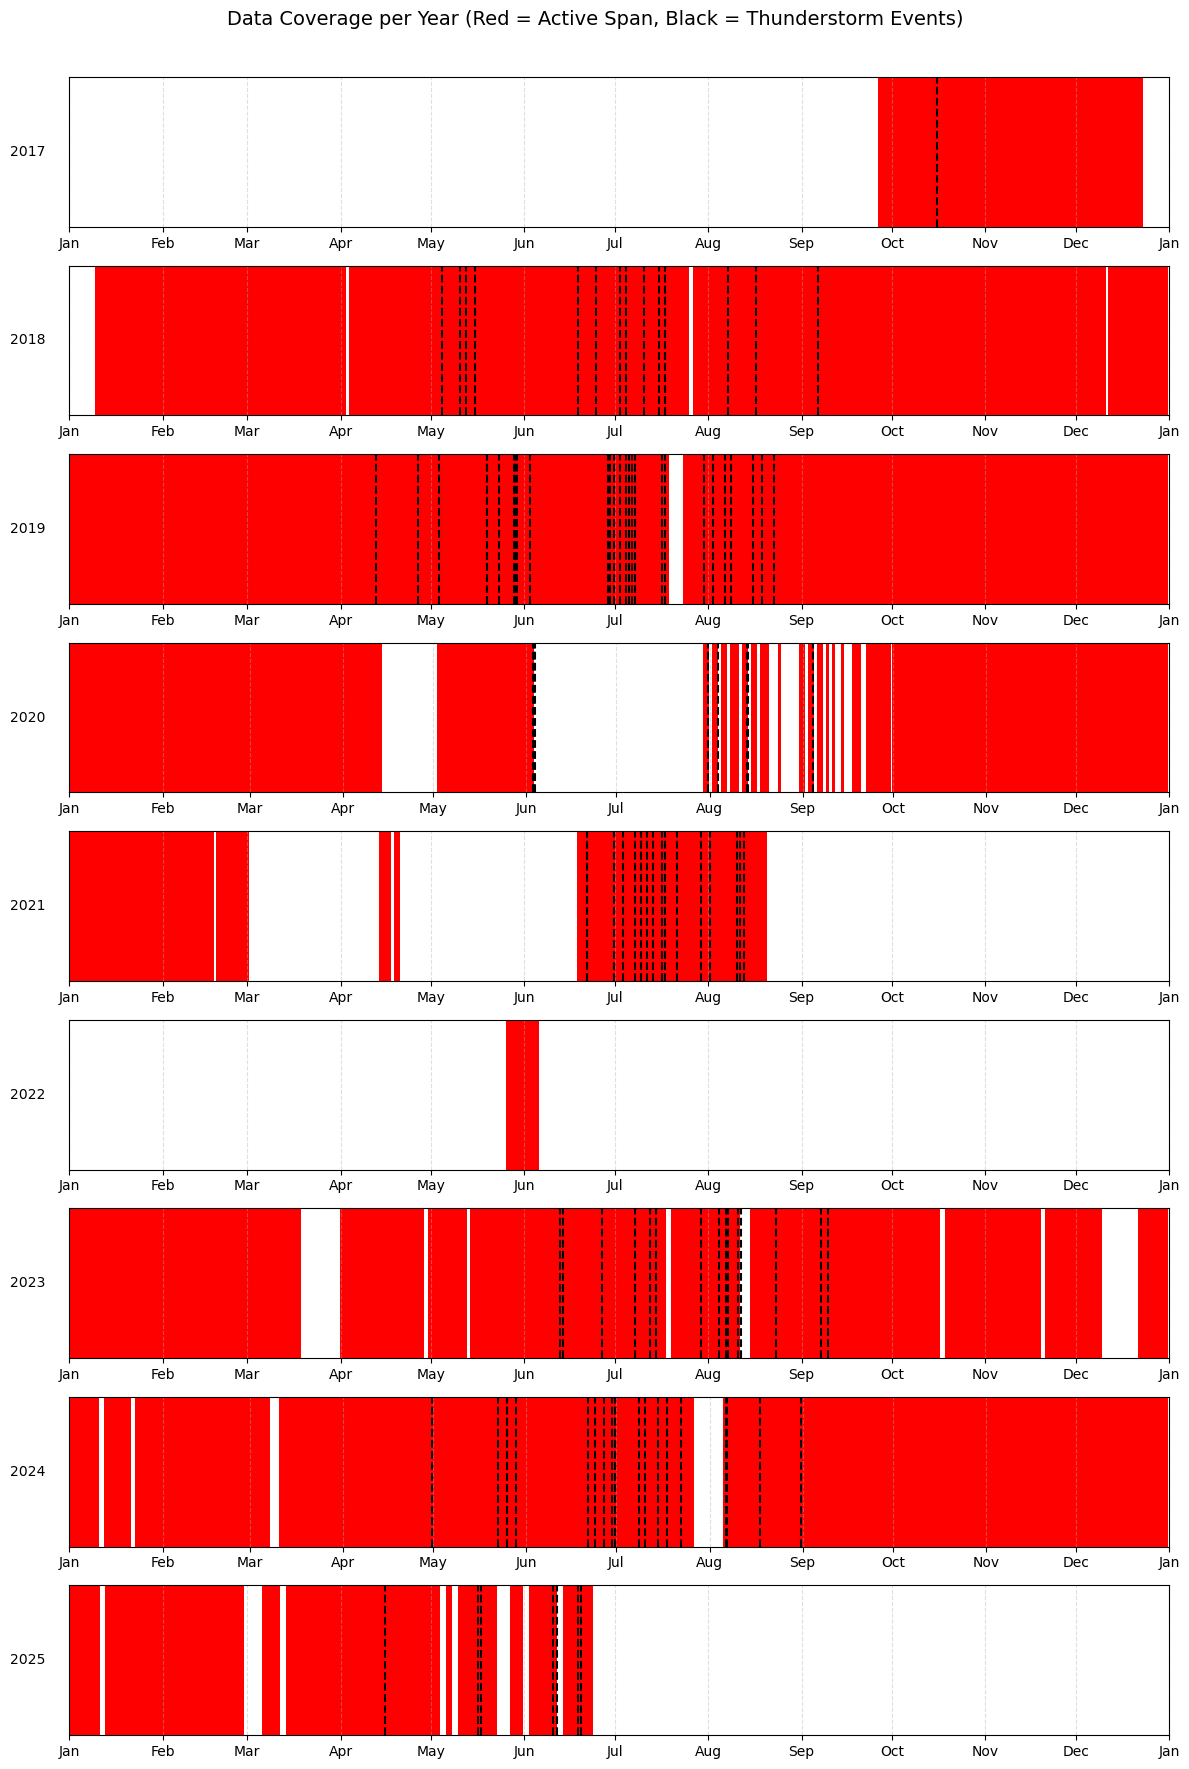

In [387]:
#If interesting:
arrays = [times[start_indices[i]:start_indices[i+1]-1] for i in range(len(start_indices) - 1)] + [times[start_indices[-1]:]]

# Convert only first and last timestamps to datetime
converted_spans = [(arr[0].datetime, arr[-1].datetime) for arr in arrays]

# Define years to plot
years = list(range(startyear, endyear+1))
n_years = len(years)

fig, axes = plt.subplots(n_years, 1, figsize=(12, 2 * n_years), sharex=False)

for ax, year in zip(axes, years):
    start_of_year = datetime(year, 1, 1)
    end_of_year = datetime(year + 1, 1, 1)

    for start, end in converted_spans:
        # Check overlap with this year
        if end > start_of_year and start < end_of_year:
            clipped_start = np.max([start, start_of_year])
            clipped_end = np.min([end, end_of_year])
            ax.broken_barh(
                [(mdates.date2num(clipped_start), (clipped_end - clipped_start).days)],
                (0, 1),
                facecolors='red'
            )

    # Style this subplot
    for i in range(len(detected_thunderstorms)):
        for j in range(len(detected_thunderstorms[i])):
            ax.axvline(x=mdates.date2num(detected_thunderstorms[i][j][0].datetime), color='black', linestyle='--')
    ax.set_xlim(start_of_year, end_of_year)
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.set_ylabel(str(year), rotation=0, labelpad=30, va='center')
    ax.grid(True, axis='x', linestyle='--', alpha=0.4)

fig.suptitle("Data Coverage per Year (Red = Active Span, Black = Thunderstorm Events)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
